#  Markdown - Project Overview
"""
# Stress Type Prediction

Predicts stress types using the [Student Stress Monitoring Datasets](https://www.kaggle.com/datasets/mdsultanulislamovi/student-stress-monitoring-datasets/data) from Kaggle. Trains DecisionTree, RandomForest, SVM, and Naive Bayes models, evaluates them, and predicts stress type from user input.

## Dataset
- **Source**: [Student Stress Monitoring Datasets](https://www.kaggle.com/datasets/mdsultanulislamovi/student-stress-monitoring-datasets/data)
- **Description**: Features include Psychological Factors, Physiological Factors, Environmental Factors, Academic Factors, Social Factors for classification.
- **License**: CC BY-SA 4.0 .

"""

# 1: Imports

In [5]:
import matplotlib
import numpy as np
import pandas as pd
from absl.logging import exception
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# 2: Load and Preprocess Data

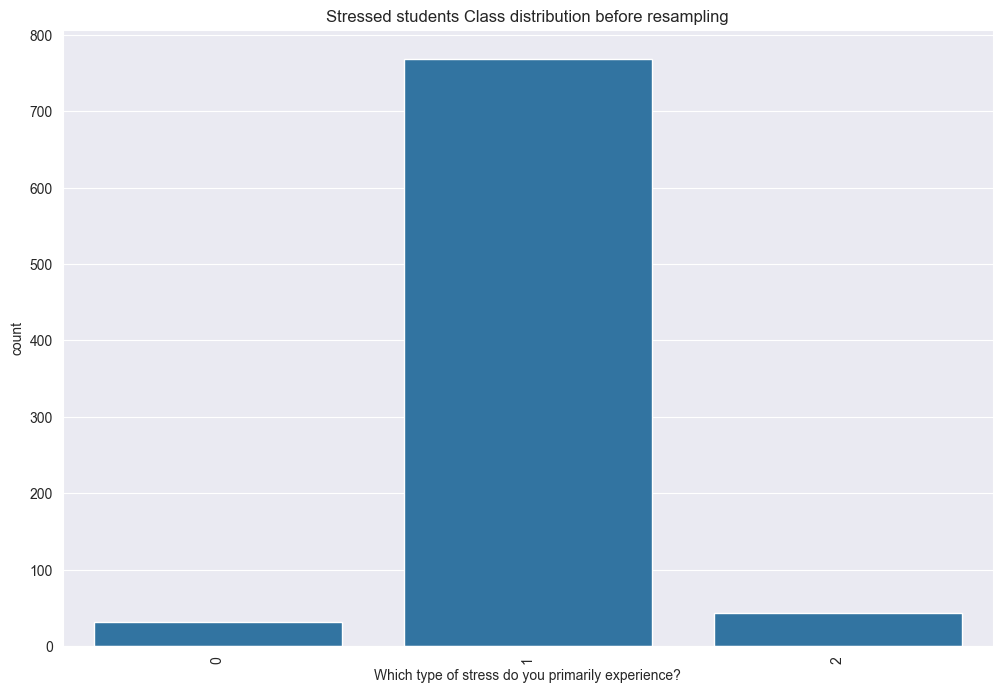

In [6]:
data=pd.read_csv('../data/Stress_Dataset.csv')
# Encode categorical columns if present
encoder = LabelEncoder()
data['Which type of stress do you primarily experience?']=encoder.fit_transform(data['Which type of stress do you primarily experience?'])
x_train=data.iloc[:,:-1]
y_train=data.iloc[:,-1]
plt.figure(figsize=(12,8))
sns.countplot(x=y_train)
plt.title('Stressed students Class distribution before resampling')
plt.xticks(rotation=90)
plt.show()
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(x_train, y_train)


# 3: Model Evaluation

In [7]:
if 'sweating' in X_resampled.columns:
    le = LabelEncoder()
    X_resampled = le.fit_transform(X_resampled)
X_resampled = X_resampled.fillna(0)
if len(y_resampled.shape) >1:
    y_resampled=y_resampled.reshape(len(y_resampled),1)
models={
    'DecisionTree':DecisionTreeClassifier(),
    'RandomForest':RandomForestClassifier(),
    'SVM':SVC(),
}
cv_scorings='accuracy'
startified_KFold=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
for model_name,model in models.items():
    try:
        scores=cross_val_score(
            model,
            X_resampled,
            y_resampled,
            cv=startified_KFold,
            scoring=cv_scorings,
            n_jobs=-1,
            error_score='raise'
        )
        print('_'*50)
        print(f'Model: {model_name}')
        print(f'scores: {scores}%')
        print(f'Mean accuracy: {scores.mean()}%')
    except Exception as ex:
        print('!'*50)
        print(f"Model: {model_name} failed with error: {ex}")



__________________________________________________
Model: DecisionTree
scores: [0.98264642 0.98047722 0.98264642 0.98915401 0.98478261]%
Mean accuracy: 0.9839413373573518%
__________________________________________________
Model: RandomForest
scores: [1.         0.9978308  0.9978308  0.99566161 1.        ]%
Mean accuracy: 0.9982646420824295%
__________________________________________________
Model: SVM
scores: [0.96529284 0.98047722 0.97396963 0.96529284 0.9826087 ]%
Mean accuracy: 0.9735282467226257%


# SVM + Confusion Matrix

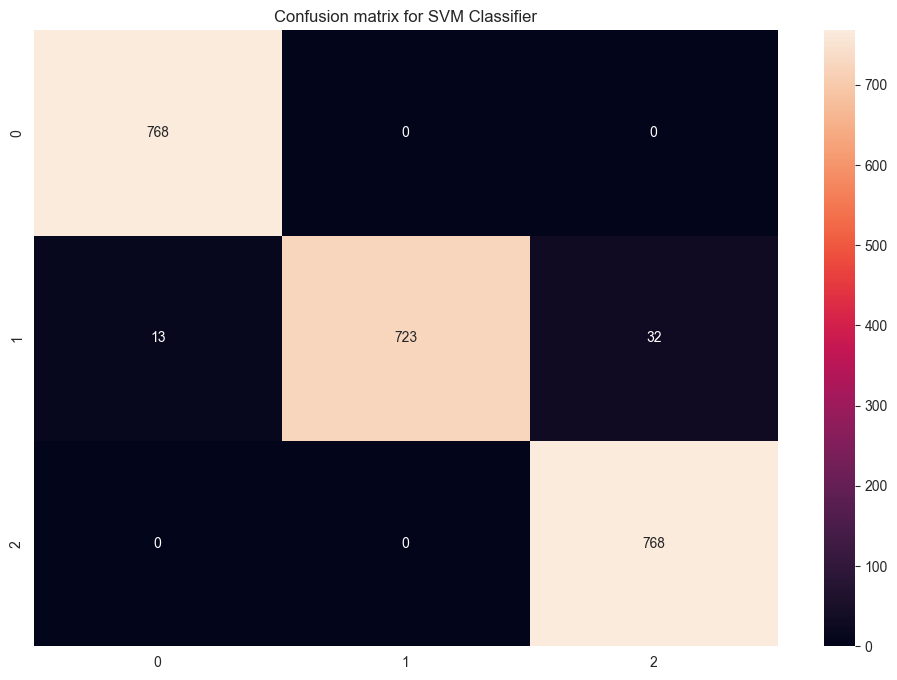

SVM Accuracy: 98.05%


In [8]:
svm_model=SVC()
svm_model.fit(X_resampled,y_resampled)
svm_preds=svm_model.predict(X_resampled)
cf=confusion_matrix(y_resampled,svm_preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf,annot=True,fmt='d')
plt.title('Confusion matrix for SVM Classifier')
plt.show()
print(f'SVM Accuracy: {svm_model.score(X_resampled,y_resampled)*100:.2f}%')

# Naive Bayes + Confusion Matrix

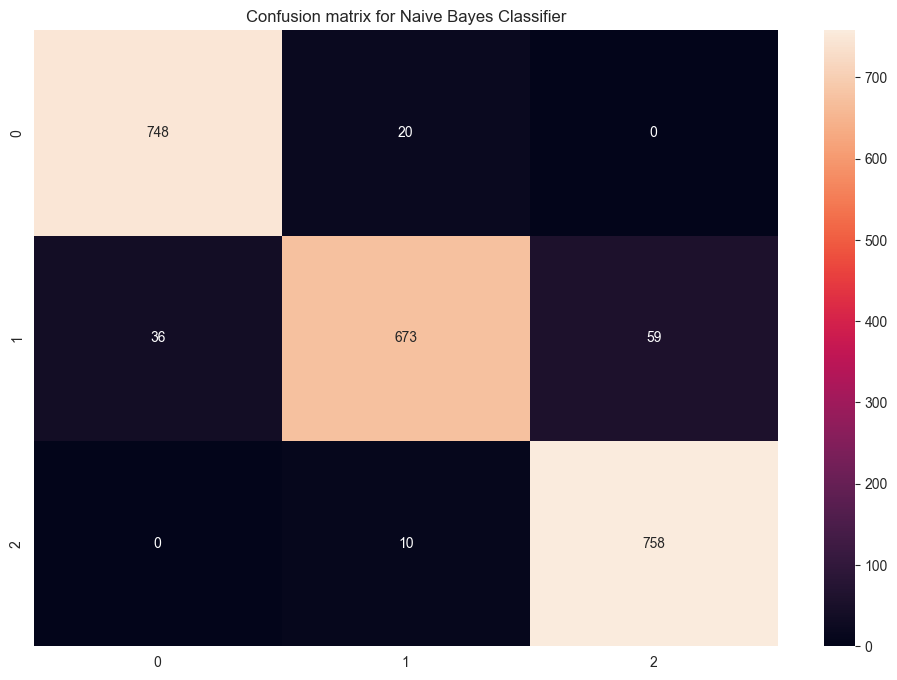

accuracy score: 94.57%


In [9]:
nb_model=GaussianNB()
nb_model.fit(X_resampled,y_resampled)
nb_preds=nb_model.predict(X_resampled)
cm=confusion_matrix(y_resampled,nb_preds)
plt.figure(figsize=(12,8))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion matrix for Naive Bayes Classifier')
plt.show()
print(f'accuracy score: {accuracy_score(y_resampled,nb_preds)*100:.2f}%')

# Random Forest + Confusion Matrix

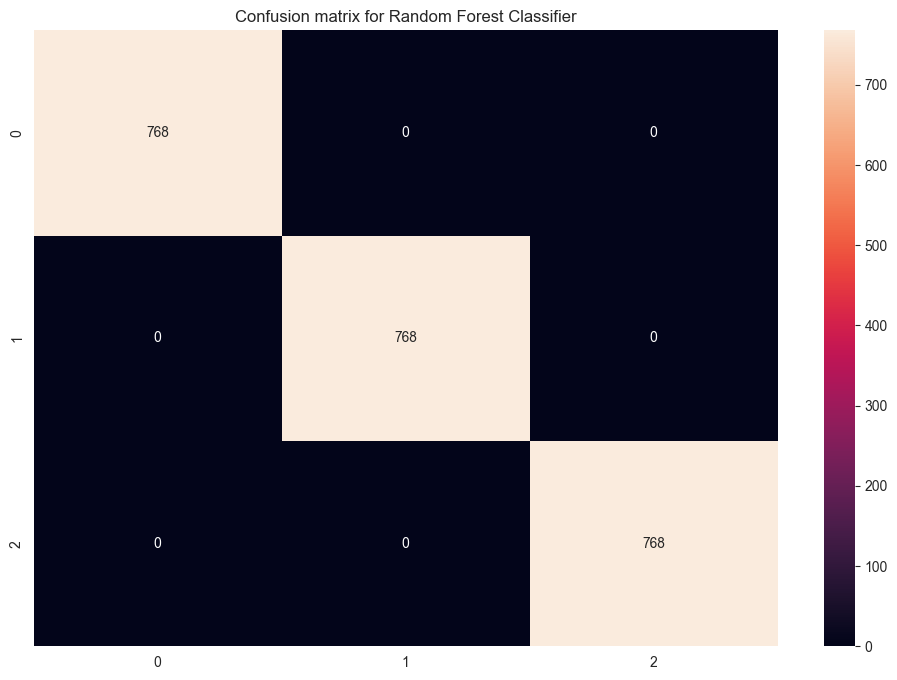

accuracy score: 100.00%


In [10]:
rf_model=RandomForestClassifier()
rf_model.fit(X_resampled,y_resampled)
rf_preds=rf_model.predict(X_resampled)
cm=confusion_matrix(y_resampled,rf_preds)
plt.figure(figsize=(12,8))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion matrix for Random Forest Classifier')
plt.show()
print(f'accuracy score: {accuracy_score(y_resampled,rf_preds)*100:.2f}%')

# 4: Survey and Prediction

In [17]:
factors=x_train.columns.values.tolist()
factors_index={factor:idx for idx,factor in enumerate(factors)}
def survey_quiz(factors):
    input_factors={}
    for factor in factors:
        ans=input(f'{factor}?(numbers only)')
        if ans.isnumeric():
            input_factors[factor] = int(ans)
    return input_factors
def predict_stress_type():
    survey_res=survey_quiz(factors)
    input_data=[0]*len(survey_res)
    for fac,val in survey_res.items():
        input_data[factors_index[fac]]=survey_res[fac]
    input_df=pd.DataFrame([input_data],columns=factors)
    rf_pred=encoder.classes_[rf_model.predict(input_df)[0]]
    nb_pred=encoder.classes_[nb_model.predict(input_df)[0]]
    svm_pred=svm_model.classes_[svm_model.predict(input_df)[0]]
    values, counts = np.unique([rf_pred, nb_pred, svm_pred], return_counts=True)
    final_pred = values[np.argmax(counts)]
    return{
        'RandomForest prediction':rf_pred,
        'NaiveBayes prediction': nb_pred,
        'SVM prediction': svm_pred,
        'final prediction': final_pred
    }
print(predict_stress_type())

KeyboardInterrupt: Interrupted by user